[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/elcursodeia-code/blob/master/ml/04_regresion.ipynb)

> Notación: 
> - Usaremos $x$ para representar que x es un valor escalar.
> - Usaremos $\bf{x}$ para representar que x es un vector.
> - Usaremos $\bf{X}$ para representar que x es una matriz.

## Regresión lineal

## Regresión lineal

Un modelo de regresión lineal realiza una predicción calculando una suma ponderada de las características de entrada más un término de sesgo:

$$
  \hat{y} = w_0 + w_1 x_1 + w_2 x_2 + ... + w_n x_n
$$

donde $\hat{y}$ es el valor predicho, $w_i$ es el $i$-ésimo parámetro del modelo (incluyendo el término de sesgo $w_0$), $n$ es el número de características y $x_i$ es la $i$-ésima característica. Podemos escribir esta expresión de una manera más concisa como

$$
  \hat{y} = \bf{w} \cdot \bf{x}
$$

donde $\bf{w}$ y $\bf{x}$ son vectores que contienen los parámetros del modelo y las características de entrada, respectivamente.

Nuestro objetivo es encontrar los valores de $\bf{w}$ que minimizan una función de costo, generalmente el Error Cuadrático Medio (MSE, por sus siglas en inglés).

$$
  MSE(\hat{y},y)  = \frac{1}{N} \sum^{N}_{j=1} (\hat{y}^{(j)} - y^{(j)})^2
$$

donde $N$ es el número de muestras y $y^{(j)}$ es el valor real de la $j$-ésima muestra en el conjunto de datos.

### La ecuación normal

La Ecuación Normal es una solución de forma cerrada para encontrar $\bf{w}$.

$$
  \hat{\bf{w}} = (\bf{X}^T \bf{X})^{-1} \bf{X}^T \bf{y}
$$

donde $\hat{\bf{w}}$ es el vector óptimo de parámetros, $\bf{X}$ es la matriz de valores de datos y $\bf{y}$ es el vector de valores reales.

In [1]:
import numpy as np

X = 2 * np.random.rand(100, 1)
#y = 4 + 3 * X + np.random.randn(100, 1)
y = 3 * X + np.random.randn(100, 1)

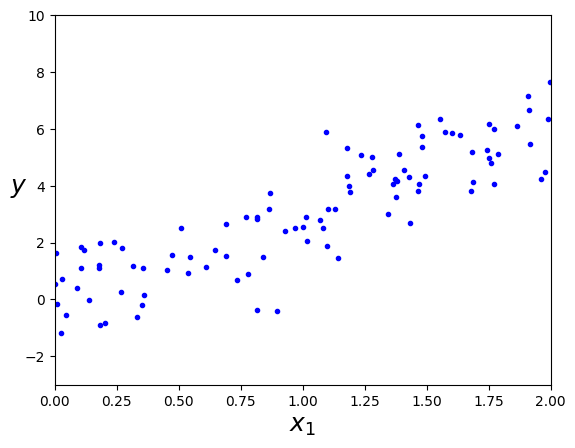

In [2]:
import matplotlib.pyplot as plt

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, -3, 10])
plt.show()

In [3]:
X_b = np.c_[np.ones((100, 1)), X]  # añadimos x0 = 1 a cada instancia
w_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
w_best

array([[-0.07616911],
       [ 3.08902031]])

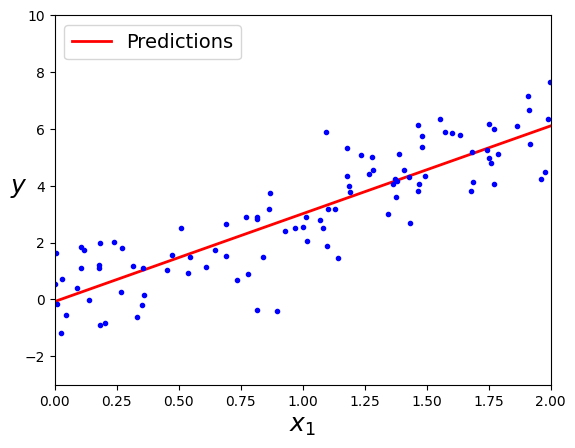

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  
y_predict = X_new_b.dot(w_best)
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, -3, 10])
plt.show()

In [5]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([-0.07616911]), array([[3.08902031]]))

### Descenso por gradiente

El algoritmo funciona de la siguiente manera:

1. Calcular la salida del modelo, $\hat{y}$.
2. Calcular el gradiente del error con respecto a los parámetros, $\frac{\partial MSE}{\partial w} = \frac{2}{N} \frac{\partial \hat{y}}{\partial w} (\hat{y} - y)$ donde $\frac{\partial \hat{y}}{\partial w} = x$.
3. Actualizar los parámetros, $w^{i+1} = w^i - \eta \frac{\partial MSE}{\partial w}$, donde $\eta$ es la tasa de aprendizaje.
4. Repetir hasta la convergencia.

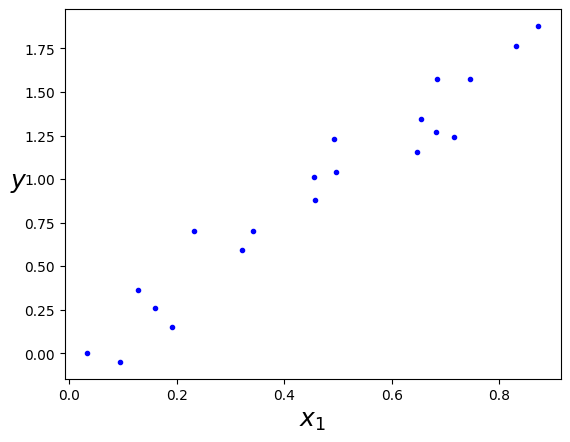

In [6]:
x = np.random.rand(20)
y = 2*x + (np.random.rand(20)-0.5)*0.5

plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.show()

In [16]:
from matplotlib import animation, rc
rc('animation', html='html5')

def init_fig(x, t, ws, cost_ws):
    """Initialise figure"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    ax2.plot(x, t, 'bo', label='target: t')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 2])
    ax2.set_xlabel('input: $x$', fontsize=15)
    ax2.set_ylabel('target: $t$', fontsize=15)
    ax2.yaxis.set_label_position('right')
    ax2.set_title('Labelled data & model output', fontsize=18)
    line2, = ax2.plot([], [], 'k-', label='fitted line: $y=x*p$')
    ax2.legend(loc=2)
    # Cost function plot
    ax1.plot(ws, cost_ws, 'r-', label='cost')
    ax1.set_ylim([-2, 8])
    ax1.set_xlim([1, 3])
    ax1.set_xlabel('parameter: $p$', fontsize=15)
    ax1.set_ylabel('cost: $\sum |t-y|^2$', fontsize=15)
    cost_text = ax1.set_title('Cost at step {}'.format(0), fontsize=18)
    line1, = ax1.plot([], [], 'k:', label='derivative at $p$')
    pc_dots, = ax1.plot([], [], 'ko')
    ax1.legend(loc=2)
    return fig, ax1, ax2, line1, line2, pc_dots, cost_text

def get_anim(fig, ax1, ax2, line1, line2, pc_dots, cost_text, weights):
    """Return animation function."""
    xs = np.linspace(0, 4, num=100)  # weight values
    def anim(i):
        """Animate step i"""
        if i == 0:
            return [line1, line2, pc_dots, cost_text]
        (w, dw, cost) = weights[i-1]
        cost_text.set_text('Cost at step {} = {:.3f}'.format(i, cost))
        ws, _, cs = zip(*weights[0:i])
        pc_dots.set_xdata(ws)
        pc_dots.set_ydata(cs)
        abline_values = [dw * (x-w) + cost for x in xs]
        line1.set_xdata(xs)
        line1.set_ydata(abline_values)
        # Plot fit
        # plot the fitted line
        line2.set_xdata([0, 1])
        line2.set_ydata([0*w, 1*w])
        ax2.legend(loc=2)
        return [line1, line2, pc_dots, cost_text]
    return anim

def gradient(w, x, t): 
    return np.sum(2.* x * (x*w - t))

def cost(y, t): 
  return ((t - y)**2).sum()

ws = np.linspace(0, 4, num=100)  
cost_ws = np.vectorize(lambda w: cost(x*w, y))(ws)  
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
plt.close(fig)  

In [17]:
w = 1
lr = 0.01
epochs = 20
weights = [(w, gradient(w, x, y), cost(x*w, y))]
for i in range(epochs):
    dw = gradient(w, x, y)
    w = w - lr*dw
    weights.append((w, dw, cost(x*w, y)))

animate = get_anim(fig, ax1, ax2, line1, line2, pc_dots, cost_text, weights)
anim = animation.FuncAnimation(fig, animate, frames=len(weights)+1, interval=200, blit=True)
anim

Dependiendo de la inicialización y la tasa de aprendizaje, el proceso de convergencia será más rápido, más lento o divergente.

Descenso de Gradiente Estocástico

In [18]:
w = 1
lr = 0.1
epochs = 2
weights = [(w, gradient(w, x, y), cost(x*w, y))]
N = x.shape[0]
ixs = np.arange(N)
for i in range(epochs):
    np.random.shuffle(ixs)
    for ix in ixs:
      _x, _y = x[ix], y[ix]
      dw = gradient(w, _x, _y)
      w = w - lr*dw
      weights.append((w, dw, cost(_x*w, _y)))

fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
plt.close(fig)  
animate = get_anim(fig, ax1, ax2, line1, line2, pc_dots, cost_text, weights)
anim = animation.FuncAnimation(fig, animate, frames=len(weights)+1, interval=200, blit=True)
anim

Descenso de Gradiente por Mini-lotes

In [20]:
w = 1
lr = 0.01
epochs = 10
batch_size = 10
weights = [(w, gradient(w, x, y), cost(x*w, y))]
ixs = np.arange(x.shape[0])
batches = x.shape[0] // batch_size
for i in range(epochs):
    np.random.shuffle(ixs)
    for i in range(batches):
      _x, _y = x[ixs[i*batch_size:(i+1)*batch_size]], y[ixs[i*batch_size:(i+1)*batch_size]]
      dw = gradient(w, _x, _y)
      w = w - lr*dw
      weights.append((w, dw, cost(_x*w, _y)))
    
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
plt.close(fig)
animate = get_anim(fig, ax1, ax2, line1, line2, pc_dots, cost_text, weights)
anim = animation.FuncAnimation(fig, animate, frames=len(weights)+1, interval=200, blit=True)
anim

## Regresión polinómica

In [21]:
import numpy.random as rnd

np.random.seed(42)

In [22]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

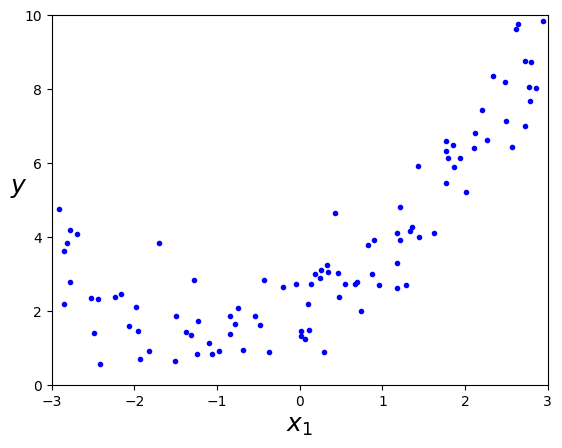

In [24]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [25]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([1.76886782]), array([1.76886782, 3.12889337]))

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.99958228]), array([[1.04630034, 0.5015459 ]]))

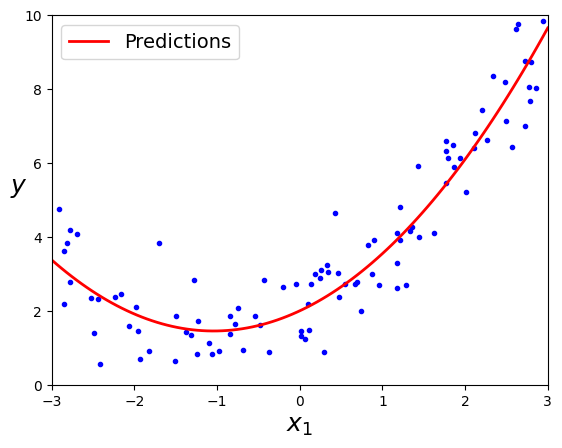

In [27]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

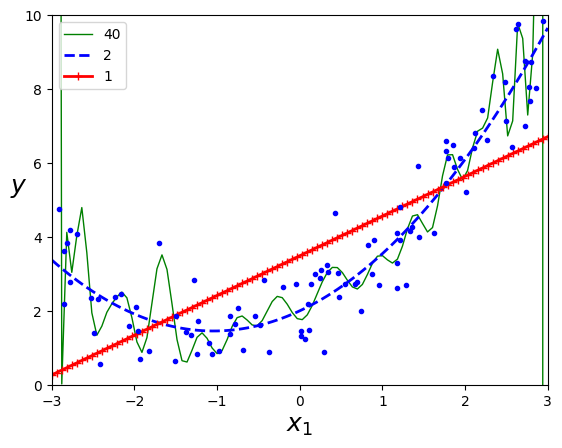

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 40), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

## Regresión Logística

Podemos usar un modelo de regresión lineal para predecir la probabilidad de que una instancia pertenezca a una clase particular, permitiendo así que el modelo realice tareas de clasificación. Para ello, necesitamos reformular el modelo de la siguiente manera:

$$
  \hat{y} = \sigma(\bf{w} \cdot \bf{x})
$$

Donde $\sigma(t) = \frac{1}{1 + e^{-t}}$ es la función sigmoide, que limitará el valor de $\hat{y}$ entre 0 y 1. Podemos interpretar la salida como una probabilidad y asumir que una instancia pertenece a una clase particular si esta probabilidad está por encima de un umbral (normalmente 0.5, pero puedes elegir un valor de acuerdo a tu balance entre precisión y exhaustividad).

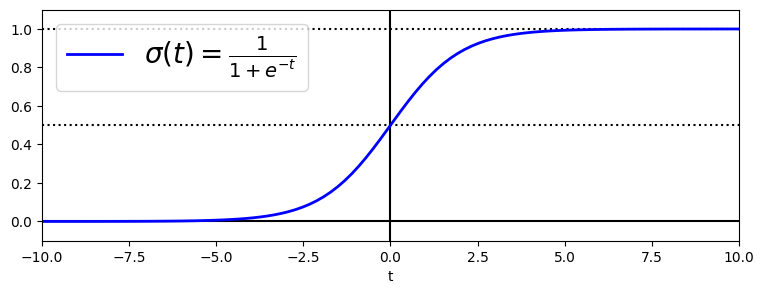

In [29]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

Para entrenar un modelo de regresión logística necesitamos una función de costo diferente, llamada función de costo de *pérdida logarítmica* (log loss).

$$
  J(\mathbf{w}) = - \frac{1}{N} \sum^{N}_{j=1} \left[ y^{(j)} log(\hat{p}^{(j)}) + (1-y^{(j)})log(1-\hat{p}^{(j)})\right]
$$

No se conoce una forma cerrada para minimizar esta función, pero el descenso de gradiente garantiza encontrar el mínimo global si la tasa de aprendizaje no es demasiado grande. Para ello, necesitamos la derivada de la función de costo con respecto a los parámetros del modelo

$$
  \frac{\partial J}{\partial w_i} =  \frac{1}{N} \sum^{N}_{j=1} (\sigma(\mathbf{w} \cdot \mathbf{x}^{(i)}) - y^{(i)})x^{(j)}_i
$$

Probemos este modelo con el conjunto de datos iris para clasificar flores en tres especies diferentes.

In [30]:
from sklearn import datasets

iris = datasets.load_iris()

In [32]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(int)  # 1 if Iris virginica, else 0

In [33]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

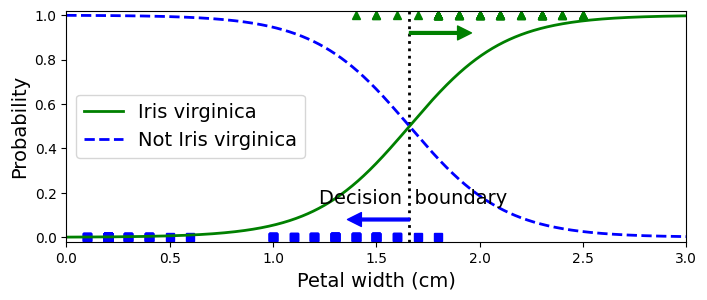

In [40]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.annotate('', xy=(decision_boundary - 0.3, 0.08), xytext=(decision_boundary, 0.08),
             arrowprops=dict(facecolor='b', edgecolor='b', width=2, headwidth=10, headlength=10))
plt.annotate('', xy=(decision_boundary + 0.3, 0.92), xytext=(decision_boundary, 0.92),
             arrowprops=dict(facecolor='g', edgecolor='g', width=2, headwidth=10, headlength=10))
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [42]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=10000000000, random_state=42)

In [43]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

/var/folders/y3/b8p5hz955g15mpwh6fvd90940000gn/T/ipykernel_53556/4088237997.py:22: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


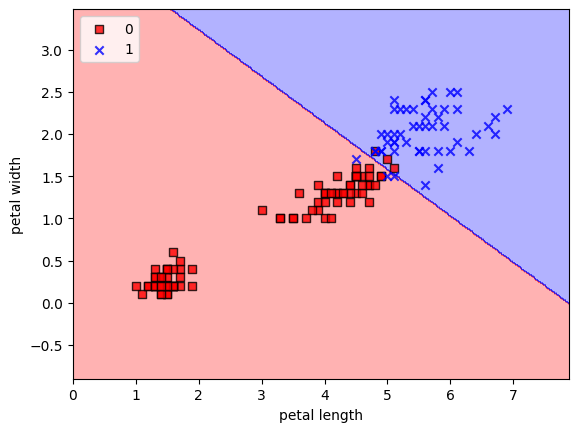

In [46]:
plot_decision_regions(X, y, log_reg)
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')
plt.show()

## Regresión softmax


El modelo de regresión logística puede generalizarse para admitir múltiples clases. Esto se llama Regresión Softmax. Dada una instancia, el modelo asignará una puntuación a cada clase y luego estimará una distribución de probabilidad.

$$
  \hat{y} = \underset{k}{\arg\max} \ \ \sigma(\mathbf{w} \cdot \mathbf{x})_k
$$

donde ahora $\sigma(t)_k = \frac{e^{t_k}}{\sum^K_{k=1} e^{t_k}}$ y $K$ es el número de clases y $t_k$ es la puntuación de cada clase para la instancia $\bf{x}$.

La función de pérdida utilizada para entrenar el modelo de regresión softmax se llama *Cross Entropy*

$$
  J(\mathbf{w}) = - \frac{1}{N} \sum^N_{j=1} \sum^K_{k=1} y_k^{(j)} log(\hat{p}_k^{(j)})
$$

donde $y_k^{(j)}$ es la probabilidad de que la $j^{ésima}$ instancia pertenezca a la clase $k$ (generalmente 1 o 0). Si $K=2$, la función de costo es equivalente a la función de costo *log loss*. El gradiente de la función de costo de entropía cruzada es

$$
  \frac{\partial J_k}{\partial \mathbf{w}} =  \frac{1}{N} \sum^{N}_{j=1} (\hat{p}_k^{(j)} - y_k^{(j)}) \mathbf{x}^{(j)}
$$

In [47]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

/Users/sensio/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [48]:
x = np.array([-4.35, 5.74, 8.16])
s = np.exp(x) / np.exp(x).sum()
s

array([3.38826945e-06, 8.16599788e-02, 9.18336633e-01])

/var/folders/y3/b8p5hz955g15mpwh6fvd90940000gn/T/ipykernel_53556/4088237997.py:22: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


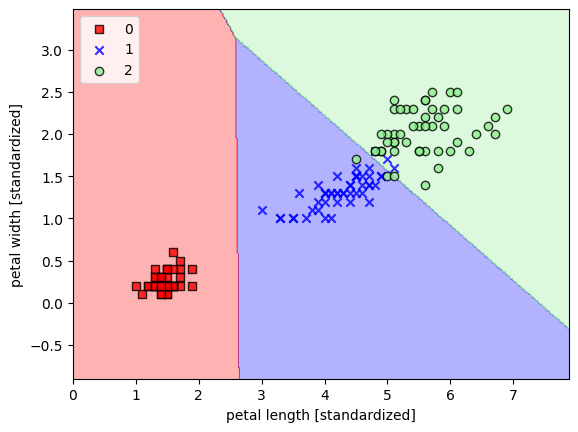

In [49]:
plot_decision_regions(X, y, softmax_reg)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

In [50]:
softmax_reg.predict([[5, 2]])

array([2])

In [51]:
softmax_reg.predict_proba([[5, 2]])

array([[6.21626375e-07, 5.73689803e-02, 9.42630398e-01]])